<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

Импортируем библиотеки 🎒

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from numpy.random import RandomState
from numpy.random import randint
from numpy.random import rand

from numpy.linalg import det

from decimal import Decimal

from matplotlib import rcParams

from scipy.stats import t
from scipy.stats import bootstrap

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.pipeline import make_pipeline

Настроим вид графиков по+красоте ✨

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
# style MATPLOTLIBRC
custom_params = {
                'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,
    
                "lines.color": '#EEEEEE',

                'text.color': '#EEEEEE',
    
                'font.family': 'sans-serif',
                # 'font.sans-serif': [
                #     'Helvetica',
                #     'Verdana',
                #     'Tahoma',
                #     'Trebuchet MS',
                #     'Arial',
                #     'Chevin'
                #     ]
                }

# rcParams.update(custom_params)

In [4]:
# set max columns to none
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

Константы.

In [5]:
RANDOM_SEED = 108108108
random_np = RandomState(128) 
dpi_k = custom_params['figure.dpi'] / rcParams['figure.dpi']
px = 1/custom_params['figure.dpi']

Функции.

In [6]:
def baisic_df_info(data_df, title='Basic Info'):
    print(title, end='\n\n')
    print('Дубликатов:',
             len(data_df.loc[data_df.duplicated()].index),
          end='\n\n'
     )
    
    display(
        data_df.info(),
        data_df.sample(5),
        data_df.describe(),
    )

In [7]:
def to_px(size_px):
    px_density = int(
        round(
            size_px * px * dpi_k
        )
    )
    return px_density

In [53]:
def plot_hist(data, title='Histogram', custom_params=custom_params):
    
    num_col = 2
    num_row = int(len(data.columns) / num_col) + (len(data.columns) % num_col)
    
    with mpl.rc_context(custom_params):
        fig, axs = plt.subplots(
            nrows=3,
            ncols=2,
            figsize=(
                to_px(960), to_px(960)),
            tight_layout=True
        )
        
        for n, col_name in enumerate(data.columns):
            ax_row = int(n/2)
            ax_col = n%2
            n_bins = len(data[col_name].unique())
                
            axs[ax_row, ax_col].hist(
                data[col_name],
                bins=n_bins,
                color='forestgreen'
            )
            # axs[n].set_xlim(0, 60)
            axs[ax_row, ax_col].set_title(col_name)
        
        fig.suptitle(title, fontsize=16)
        
        if len(data.columns) % num_col:
            fig.delaxes(axs[-1, -1])

        plt.show()
        
        # return to_descr

## Загрузка данных

### 1.1. Загрузим файл и изучим данные

In [9]:
try:
    insurance_df = pd.read_csv(
        './datasets/insurance.csv',
        # index_col='date',
    )
    
except FileNotFoundError:
    insurance_df = pd.read_csv(
        'https://code.s3.yandex.net/datasets/insurance.csv',
        # index_col='date',
    )
    print('FYI datasets loaded via url')

In [10]:
baisic_df_info(insurance_df)

Basic Info

Дубликатов: 153

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

Пол  Возраст  Зарплата  Члены семьи  Страховые выплаты
2598    1     35.0   43500.0            0                  0
333     0     32.0   25600.0            1                  0
3456    1     50.0   43300.0            1                  2
2827    1     33.0   39900.0            0                  0
689     0     22.0   29000.0            0                  0

Пол      Возраст      Зарплата  Члены семьи  Страховые выплаты
count  5000.000000  5000.000000   5000.000000  5000.000000        5000.000000
mean      0.499000    30.952800  39916.360000     1.194200           0.148000
std       0.500049     8.440807   9900.083569     1.091387           0.463183
min       0.000000    18.000000   5300.000000     0.000000           0.000000
25%       0.000000    24.000000  33300.000000     0.000000           0.000000
50%       0.000000    30.000000  40200.000000     1.000000           0.000000
75%       1.000000    37.000000  46600.000000     2.000000           0.000000
max       1.000000    65.000000  79000.000000     6.000000           5.000000

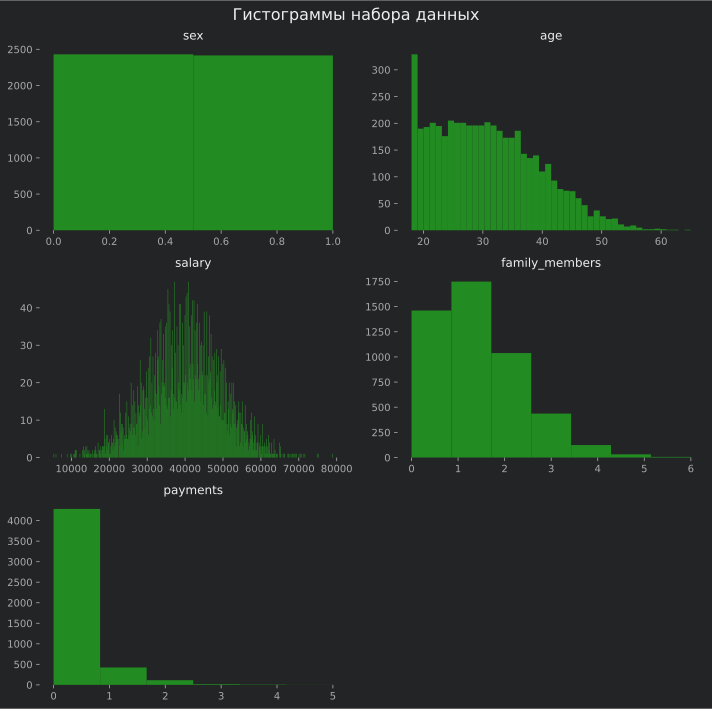

In [54]:
plot_hist(insurance_df, title='Гистограммы набора данных')

### 1.2. Подготовим данные

Удалим дубликаты. Будь у нас `user_id` можно было бы понять дубликаты это или одинаковые данные разных пользователей.

In [12]:
insurance_df.drop_duplicates(keep='first', inplace=True)

In [13]:
nice_col_names = {
    'Пол': 'sex',
    'Возраст': 'age',
    'Зарплата': 'salary',
    'Члены семьи': 'family_members',
    'Страховые выплаты': 'payments'
}
insurance_df.rename(
    columns=nice_col_names,
    inplace=True,
)

In [14]:
display(
    list(insurance_df.columns)
)

['sex', 'age', 'salary', 'family_members', 'payments']

In [15]:
target = insurance_df['payments']
target = target.astype('uint8')
features = insurance_df.drop(columns='payments')

In [16]:
features_train, features_test, target_train, target_test = train_test_split(
        features,
        target,
        test_size=0.25,
        random_state=RANDOM_SEED
    )

In [17]:
mm_scaler = MinMaxScaler()

In [18]:
mm_scaler.fit(features_train)

MinMaxScaler()

MinMaxScaler

In [19]:
mm_scaler_cv = MinMaxScaler()

##### LinearRegression

In [20]:
lin_reg = LinearRegression()

In [21]:
mm_scale_lin_reg = make_pipeline(
    mm_scaler_cv,
    lin_reg
)

In [22]:
# create a KFold object with 5 splits 
folds = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_SEED
)
r2_scores = cross_val_score(
    mm_scale_lin_reg,
    features_train,
    target_train,
    scoring='r2',
    cv=folds
)

In [23]:
display(
    r2_scores
)

array([0.44521413, 0.43896842, 0.44454333, 0.44806854, 0.4270044 ])

In [24]:
features_train_scaled = mm_scaler.transform(features_train)

In [25]:
lin_reg.fit(features_train_scaled, target_train)

LinearRegression()

In [26]:
features_test_scaled = mm_scaler.transform(features_test)

In [27]:
target_pred = lin_reg.predict(features_test_scaled)

In [28]:
r2 = r2_score(target_test, target_pred)

In [29]:
display(
    r2
)

0.3776796669992687

## Умножение матриц

In [30]:
features_t = np.transpose(features)

Зададим матрицу `ключ` с проверкой обратимости.

In [31]:
n_col = len(features.index)

In [32]:
run = True
while run:
    key = rand(
        n_col, n_col
    )
    if det(key) != 0:
        run = False

/home/bionic/.local/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Умножим параметры на матрицу ключ.

In [33]:
to_alice = np.dot(features_t, key)

In [34]:
display(
    to_alice
)

array([[1.20407881e+03, 1.19519498e+03, 1.18932336e+03, ...,
        1.22353015e+03, 1.21518049e+03, 1.21834569e+03],
       [7.47938798e+04, 7.44942954e+04, 7.40960668e+04, ...,
        7.54597119e+04, 7.56447669e+04, 7.55239028e+04],
       [9.63117223e+07, 9.57169089e+07, 9.53838999e+07, ...,
        9.75703967e+07, 9.70946873e+07, 9.73569835e+07],
       [2.90751710e+03, 2.86651490e+03, 2.83748923e+03, ...,
        2.91375227e+03, 2.93216809e+03, 2.96328159e+03]])

In [36]:
plot_hist(
    pd.DataFrame(
        np.transpose(to_alice),
        columns=['sex', 'age', 'salary', 'family_members']
    ),
    title='Гистограммы зашифрованных параметров'
)

Дешифруем матрицу обратно.

In [37]:
features_unencrypted = np.dot(to_alice, np.linalg.inv(key))

In [38]:
features_unencrypted = np.transpose(features_unencrypted)

In [39]:
display(
    features_unencrypted
)

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-1.25055521e-11,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [ 6.53699317e-12,  2.90000000e+01,  2.10000000e+04,
         1.36424205e-12],
       ...,
       [-2.72848411e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

In [40]:
features_unencrypted = pd.DataFrame(
        features_unencrypted,
        columns=['sex', 'age', 'salary', 'family_members']
    )

In [41]:
display(
    features_unencrypted.head()
)

sex   age        salary  family_members
0  1.000000e+00  41.0  49600.000001    1.000000e+00
1 -1.250555e-11  46.0  37999.999999    1.000000e+00
2  6.536993e-12  29.0  21000.000000    1.364242e-12
3 -7.958079e-12  21.0  41699.999999    2.000000e+00
4  1.000000e+00  28.0  26099.999999   -2.728484e-12

In [42]:
features_unen_train, features_unen_test, target_train, target_test = train_test_split(
        features_unencrypted,
        target,
        test_size=0.25,
        random_state=RANDOM_SEED
    )

In [43]:
features_unen_train_sc = mm_scaler.transform(features_unen_train)
features_unen_test_sc = mm_scaler.transform(features_unen_test)

In [44]:
r2_unen_scores = cross_val_score(
    mm_scale_lin_reg,
    features_unen_train,
    target_train,
    scoring='r2',
    cv=folds
)

In [45]:
display(
    r2_unen_scores,
    r2_scores
)

array([0.44521413, 0.43896842, 0.44454333, 0.44806854, 0.4270044 ])

array([0.44521413, 0.43896842, 0.44454333, 0.44806854, 0.4270044 ])

In [46]:
target_unen_pred = lin_reg.predict(features_unen_test_sc)

In [47]:
r2_unen = r2_score(target_test, target_pred)

In [48]:
display(
    r2_unen,
    r2
)

0.3776796669992687

0.3776796669992687

> ### Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

Нет, качество после шифровки и дешифровки не изменилось..

> ### Укажите, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

Если отправим Алисе:
- матрицу `ключ`
- названия колонок
- `target`
- обученный `Scaler`
- обученную `LinearRegression`
то она вполне сможет использовать данные..

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** ...

**Обоснование:** ...

> ### Предложите алгоритм преобразования данных для решения задачи.

> ### Обоснуйте, почему качество линейной регрессии не поменяется.

> ### Запрограммируйте этот алгоритм, применив матричные операции.

> ### Проверьте, что качество линейной регрессии из sklearn не отличается до и после преобразования.

## Алгоритм преобразования

**Алгоритм**

...

**Обоснование**

...

## Проверка алгоритма

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные загружены
- [ ]  Выполнен шаг 2: получен ответ на вопрос об умножении матриц
    - [ ]  Указан правильный вариант ответа
    - [ ]  Вариант обоснован
- [ ]  Выполнен шаг 3: предложен алгоритм преобразования
    - [ ]  Алгоритм описан
    - [ ]  Алгоритм обоснован
- [ ]  Выполнен шаг 4: алгоритм проверен
    - [ ]  Алгоритм реализован
    - [ ]  Проведено сравнение качества моделей до и после преобразования